# Reading and Processing Data from STAC

We will query a STAC catalog for Sentinel-2 imagery and load a single image using XArray. We will also apply some data processing to clip the image and calculate spectral indices.

## Setup and Data Download

The following blocks of code will install the required packages and download the datasets to your Colab environment.

In [ ]:
%%capture
if 'google.colab' in str(get_ipython()):
    !pip install pystac-client
    !apt install libspatialindex-dev
    !pip install fiona shapely pyproj rtree
    !pip install geopandas folium stackstac rioxarray mapclassify

In [4]:
import json
import geopandas as gpd
from shapely.geometry import mapping
import pandas as pd
import pystac_client
import os
import folium
from folium import Figure
import stackstac
import rioxarray
import matplotlib.pyplot as plt
import mapclassify

In [5]:
data_folder = 'data'
output_folder = 'output'

if not os.path.exists(data_folder):
    os.mkdir(data_folder)
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

In [6]:
def download(url):
    filename = os.path.join(data_folder, os.path.basename(url))
    if not os.path.exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

download('https://github.com/spatialthoughts/python-tutorials/raw/main/data/' +
         'bangalore.geojson')

## Procedure

Let's use Element84 search endpoint to look for items from the sentinel-2-l2a collection on AWS

In [7]:
catalog = pystac_client.Client.open('https://earth-search.aws.element84.com/v1')

In [8]:
aoi_file = 'bangalore.geojson'
aoi_filepath = os.path.join(data_folder, aoi_file)
aoi = gpd.read_file(aoi_filepath)

In [9]:
geometry = aoi.unary_union
geometry_geojson = json.dumps(mapping(geometry))

In [56]:
year = 2023
month = 5
time_range = f'{year}-{month:02}'

search = catalog.search(
    collections=['sentinel-2-c1-l2a'],
    intersects=geometry_geojson,
    datetime=time_range,
    query={'eo:cloud_cover': {'lt': 30},  'mgrs:grid_square': {'eq': 'GQ'}},
)
items = search.item_collection()
len(items)

3

In [57]:
items_df = gpd.GeoDataFrame.from_features(items.to_dict(), crs='EPSG:4326')
items_df

,geometry,created,platform,constellation,instruments,eo:cloud_cover,proj:epsg,proj:centroid,mgrs:utm_zone,mgrs:latitude_band,...,s2:datatake_type,s2:datastrip_id,s2:reflectance_conversion_factor,datetime,earthsearch:payload_id,storage:platform,storage:region,storage:requester_pays,processing:software,updated
0,"POLYGON ((76.91564 13.56109, 76.84550 13.24623...",2024-01-09T23:42:37.136Z,sentinel-2b,sentinel-2,[msi],2.518261,32643,"{'lat': 13.05694, 'lon': 77.35528}",43,P,...,INS-NOBS,S2B_OPER_MSI_L2A_DS_2BPS_20230528T074759_S2023...,0.975342,2023-05-28T05:25:24.277000Z,roda-sentinel-2-c1-l2a/workflow-sentinel-2-c1-...,AWS,us-west-2,False,{'sentinel-2-c1-l2a-to-stac': 'v2023.12.01'},2024-01-09T23:42:37.136Z
1,"POLYGON ((76.90964 13.56114, 76.84571 13.27415...",2024-01-09T22:58:15.252Z,sentinel-2a,sentinel-2,[msi],23.335014,32643,"{'lat': 13.05758, 'lon': 77.35441}",43,P,...,INS-NOBS,S2A_OPER_MSI_L2A_DS_2APS_20230523T090456_S2023...,0.977263,2023-05-23T05:25:22.897000Z,roda-sentinel-2-c1-l2a/workflow-sentinel-2-c1-...,AWS,us-west-2,False,{'sentinel-2-c1-l2a-to-stac': 'v2023.12.01'},2024-01-09T22:58:15.252Z
2,"POLYGON ((76.91223 13.56112, 76.84563 13.26250...",2024-01-10T15:47:53.001Z,sentinel-2b,sentinel-2,[msi],4.636491,32643,"{'lat': 13.05732, 'lon': 77.35477}",43,P,...,INS-NOBS,S2B_OPER_MSI_L2A_DS_2BPS_20230518T091909_S2023...,0.979355,2023-05-18T05:25:24.510000Z,roda-sentinel-2-c1-l2a/workflow-sentinel-2-c1-...,AWS,us-west-2,False,{'sentinel-2-c1-l2a-to-stac': 'v2023.12.01'},2024-01-10T15:47:53.001Z


In [58]:
fig = Figure(width=800, height=400)
m = folium.Map()
bounds = items_df.total_bounds
m.fit_bounds([[bounds[1],bounds[0]], [bounds[3],bounds[2]]])

items_df.explore(m=m,
                 color='black',
                 tooltip=['created'],
                 style_kwds={'fillOpacity': 0.2, 'weight': 0.5},)
aoi.explore(m=m, color='blue')
fig.add_child(m)


In [59]:
stack = stackstac.stack(items, resolution=10)
stack

C:\Users\ujava\anaconda3\envs\eocloud\Lib\site-packages\stackstac\prepare.py:408: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


<xarray.DataArray 'stackstac-a95fee2162b54c6224f5f427b95a6391' (time: 3,
                                                                band: 19,
                                                                y: 11179,
                                                                x: 11184)> Size: 57GB
dask.array<fetch_raster_window, shape=(3, 19, 11179, 11184), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/59)
  * time                                     (time) datetime64[ns] 24B 2023-0...
    id                                       (time) <U30 360B 'S2B_T43PGQ_202...
  * band                                     (band) <U8 608B 'red' ... 'preview'
  * x                                        (x) float64 89kB 6.992e+05 ... 8...
  * y                                        (y) float64 89kB 1.501e+06 ... 1...
    instruments                              <U3 12B 'msi'
    ...                                       ...
    file:checksum                            (band) object 152B None ... None
    file:size                                (band) object 152B None ... None
    common_name                              (band) object 152B 'red' ... None
    center_wavelength                        (band) object 152B 0.665 ... None
    full_width_half_max                      (band) object 152B 0.038 ... None
    epsg                                     int32 4B 32643
Attributes:
    spec:        RasterSpec(epsg=32643, bounds=(699160, 1389220, 811000, 1501...
    crs:         epsg:32643
    transform:   | 10.00, 0.00, 699160.00|\n| 0.00,-10.00, 1501010.00|\n| 0.0...
    resolution:  10

In [60]:
scene = stack.isel(time=0).sel(band=['red', 'green', 'blue', 'nir', 'swir16'])
scene

<xarray.DataArray 'stackstac-a95fee2162b54c6224f5f427b95a6391' (band: 5,
                                                                y: 11179,
                                                                x: 11184)> Size: 5GB
dask.array<getitem, shape=(5, 11179, 11184), dtype=float64, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/59)
    time                                     datetime64[ns] 8B 2023-05-18T05:...
    id                                       <U30 120B 'S2B_T43PGQ_20230518T0...
  * band                                     (band) <U8 160B 'red' ... 'swir16'
  * x                                        (x) float64 89kB 6.992e+05 ... 8...
  * y                                        (y) float64 89kB 1.501e+06 ... 1...
    instruments                              <U3 12B 'msi'
    ...                                       ...
    file:checksum                            (band) object 40B None ... None
    file:size                                (band) object 40B None ... None
    common_name                              (band) object 40B 'red' ... 'swi...
    center_wavelength                        (band) object 40B 0.665 ... 1.61
    full_width_half_max                      (band) object 40B 0.038 ... 0.143
    epsg                                     int32 4B 32643
Attributes:
    spec:        RasterSpec(epsg=32643, bounds=(699160, 1389220, 811000, 1501...
    crs:         epsg:32643
    transform:   | 10.00, 0.00, 699160.00|\n| 0.00,-10.00, 1501010.00|\n| 0.0...
    resolution:  10

In [61]:
geometry = aoi.to_crs(scene.rio.crs).geometry
clipped = scene.rio.clip(geometry)
clipped

<xarray.DataArray 'stackstac-a95fee2162b54c6224f5f427b95a6391' (band: 5,
                                                                y: 3427, x: 3510)> Size: 481MB
dask.array<getitem, shape=(5, 3427, 3510), dtype=float64, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/60)
    time                                     datetime64[ns] 8B 2023-05-18T05:...
    id                                       <U30 120B 'S2B_T43PGQ_20230518T0...
  * band                                     (band) <U8 160B 'red' ... 'swir16'
  * x                                        (x) float64 28kB 7.67e+05 ... 8....
  * y                                        (y) float64 27kB 1.454e+06 ... 1...
    instruments                              <U3 12B 'msi'
    ...                                       ...
    file:size                                (band) object 40B None ... None
    common_name                              (band) object 40B 'red' ... 'swi...
    center_wavelength                        (band) object 40B 0.665 ... 1.61
    full_width_half_max                      (band) object 40B 0.038 ... 0.143
    epsg                                     int32 4B 32643
    spatial_ref                              int32 4B 0
Attributes:
    spec:        RasterSpec(epsg=32643, bounds=(699160, 1389220, 811000, 1501...
    resolution:  10

In [62]:
%time clipped = clipped.compute()

CPU times: total: 14.1 s
Wall time: 1min 40s


In [63]:
rgb = clipped.sel(band=['red', 'green', 'blue'])

C:\Users\ujava\anaconda3\envs\eocloud\Lib\site-packages\matplotlib\cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


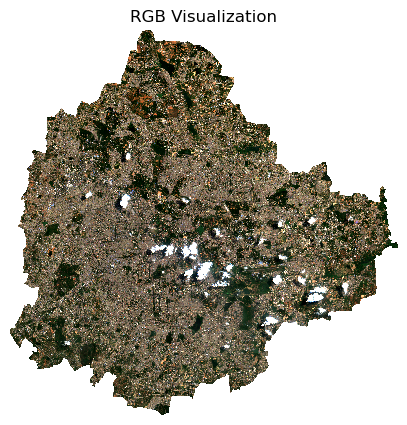

In [64]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(5,5)
rgb.plot.imshow(
    ax=ax,
    robust=True)
ax.set_title('RGB Visualization')
ax.set_axis_off()
plt.show()

In [65]:
red = clipped.sel(band='red')
nir = clipped.sel(band='nir')
green = clipped.sel(band='green')
swir1 = clipped.sel(band='swir16')

mndwi = (green - swir1)/(green + swir1)
ndvi = (nir - red)/(nir + red)

In [66]:
%%time

date_string = str(scene.time.dt.strftime('%Y_%m').values)

files = {
    f'rgb_{date_string}.tif': rgb,
    f'ndvi_{date_string}.tif': ndvi,
    f'mndwi_{date_string}.tif': mndwi
}

for file in files:
  output_path = os.path.join(output_folder, file)
  files[file].rio.to_raster(output_path, driver='COG')
  print(f'Wrote {file}')

Wrote rgb_2023_05.tif
Wrote ndvi_2023_05.tif
Wrote mndwi_2023_05.tif
CPU times: total: 7.62 s
Wall time: 12.5 s
